<a href="https://colab.research.google.com/github/andersthequeen/cis545/blob/master/New_York_Times_Review_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New York Times Restaurant Review Ratings Predictor
### **Due Date: April 29, 2020**
### **Deliverable Two Video Link:**
https://youtu.be/MA1mlpJNqWE

### **Goal of Project**
The goal of the New York Times Restaurant Review Ratings Predictor is quite simple – to predict the number of stars the New York Times will award to any one specific restaurant based on the information the New York Times provides regarding the restaurant.

*The idea is this:* in the unlikely event that the ratings for each review on the New York Times disappeared, my model would hopefully be able to estimate what the ratings *would have been* based on the contents of the article.

### **Structure of Project**

1. Scraping the New York Times
2. Gathering Article Data
3. Cleaning and Piecing Article Data
4. Implementing Machine Learning

###**Selenium and Scraping the New York Times**
This is a screenshot of the main New York Times dining website, where all of our restaurant information is located. 

Our goal is to scrape as much information as possible from the website and its articles. Our first task is to scrape the main page. The problem is, however, this page is not infinitely scrollable. At the very bottom, there is a *show more* button that requires clicking. Because the page is very large, ideally, we would want an automative process to go through each article and scrape the data for us.

The url is here: https://www.nytimes.com/reviews/dining. 

![alt text](https://drive.google.com/uc?id=1K1NB8yIPY8fVaZamplL1u039glhDtyRC)


# Part 1: Scraping the New York Times


**Step One: Run installations.**



In [0]:
%%capture
!pip3 install requests_html
!pip3 install selenium

import time
import re
import os
import io
import urllib
import requests
import datetime
import pandas as pd
from lxml import html
from lxml import etree
from google.colab import files
from io import StringIO, BytesIO
from requests_html import HTML, HTMLSession
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

**Step Two: Run more installations.**

In [0]:
%%capture
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

**Step Three: Scraping the New York Times website.**

![alt text](https://drive.google.com/uc?id=1cHK-LKFIHgbD3nx25deCbuG4-_CduY9q)

To automatically scrape the article, we use `Selenium` to generate a headless browser and execute the following commands iteratively:

1. First, we create a headless browser that houses the article. 
```
driver = webdriver.Chrome('chromedriver', chrome_options = chrome_options)
driver.get("https://www.nytimes.com/reviews/dining")
```
2. Next, we 'scroll' to the very top of the article and we wait for all of the restaurant reviews to pop up onto the screen.
```
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
elements = WebDriverWait(driver, 20).until(EC.visibility_of_all_elements_located
                                             ((By.CSS_SELECTOR,"article.css-lgadl5")))
```
3. Once all the restaurant reviews pop up on the screen, we scrape each one individually for information. In particular, we are looking to fill the following columns:
```
['Restaurant', 'URL', 'servesCuisine', 'priceRange', 'addressLocality', 'date', 'rating']
```
To fill these columns, we use the selenium function `find_elements_by_tag_name` to access article information.

4. Once we have harvested data from all the restaurants in view, we wait to make sure that the *show more* button is visible at the bottom of the screen. If it is, we click, revealing more restaurant reviews, thus starting the process all over again.
```
    button = WebDriverWait(driver, 10).until(EC.visibility_of_element_located
                                             ((By.XPATH,"//button[text()='Show More']")))
    driver.execute_script("arguments[0].click();", button)
```




In [0]:
# 1. Initiating the webdriver
driver = webdriver.Chrome('chromedriver', chrome_options = chrome_options)
driver.get("https://www.nytimes.com/reviews/dining")

# 2. To accept the coockie click on that
WebDriverWait(driver, 20).until(EC.element_to_be_clickable
                                ((By.XPATH,"//button[text()='Show More']"))).click()
url_list = []
nyt_dining = pd.DataFrame(columns = ['Restaurant', 'URL', 'servesCuisine', 
                                     'priceRange', 'addressLocality', 'date', 'rating'])

x = 0 
while(True):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    elements = WebDriverWait(driver, 20).until(EC.visibility_of_all_elements_located
                                             ((By.CSS_SELECTOR,"article.css-lgadl5")))
    print(str(len(elements)) + ' elements')
    if len(elements) > 60:
      elements = elements[-50:]
    url_before = len(url_list)
    for e in elements:
      # 2.1 Getting the links
      link = e.find_element_by_css_selector("a.css-gg4vpm")
      link = link.get_attribute("href")

      if link in url_list:
        continue
      else:
        # 2.1 Getting the restaurant name
        name = e.find_element_by_css_selector("h2.css-8aqwnr")
        name = name.text
        
        # 2.3 Getting other information
        info = e.find_element_by_css_selector("ul.css-o4kdzz")
        info = info.find_elements_by_tag_name('li')
        cuisine = ''
        price = ''
        neighborhood = ''
        
        for i in info:
          attribute = i.get_attribute("itemprop")
          if attribute == "servesCuisine":
            cuisine = i.text
          elif attribute == "priceRange":
            price = i.text
          elif attribute == "addressLocality":
            neighborhood = i.text
        
        rating = e.find_elements_by_tag_name("span")
        for rate in rating:
          verify = rate.get_attribute("class")
          if verify == "css-1dv1kvn":
            rate = rate.get_attribute("innerHTML")
            rating = rate

        date = e.find_element_by_tag_name("time")
        date = date.text
        
        # 2.4 Append to dataframe
        url_list.append(link)
        nyt_dining = nyt_dining.append({'Restaurant': name, 'URL': link,
                                        'servesCuisine': cuisine,
                                        'priceRange': price,
                                        'addressLocality': neighborhood,
                                        'date': date, 'rating': rating}, 
                                       ignore_index = True)
      print(str(x) + ' in')
      x += 1

    url_after = len(url_list)
    if url_before >= url_after:
      break
    button = WebDriverWait(driver, 10).until(EC.visibility_of_element_located
                                             ((By.XPATH,"//button[text()='Show More']")))
    driver.execute_script("arguments[0].click();", button)
    time.sleep(2)

nyt_dining

**Step Four: Load `nyt_dining` into an Excel file and upload to Github.**

In [0]:
nyt_dining.to_excel("nyt_dining.xlsx")
files.download("nyt_dining.xlsx")

In [0]:
nyt_dining = pd.read_excel("https://github.com/andersthequeen/cis545/blob/master/nyt_dining.xlsx?raw=true", 
                           headers = True, index_col = 0)

**Step Five: Convert the `rating` column.**

In [0]:
def rating(x):
  if x is not None:
    x = x.strip()
    if len(x) < 20:
      nums = re.findall(r'\d+', x)
      if len(nums) == 1:
        return float(nums[0])
      elif len(nums) == 2:
        return (float(nums[0] + '.' + nums[1]))
      else:
        return 0.0
    else:
      return 0.0
  else:
    return 0.0
nyt_dining['rating'] = nyt_dining['rating'].apply(lambda x: rating(x))

**Plot**

Here, we plot the number of restaurants categorized into each rating. Some basic insights:

*   About 800 restaurants fall into the "0.0" category. These are restaurants that either aren't rated or have garnered a poor — 0.25 — fair — 0.50 — or satisfactory — 0.75 — rating.
*   Of the "starred" restaurants, the most common award is two stars, which is designated as "Very Good." 
*   There are about 200 restaurants in the New York Times that have earned one star, which is designated as "Good."
*   Fewer than 100 restaurants have attained three stars, designated as "Excellent," and only 3 restaurants in total have achieved four stars, designated as "Extraordinary."



In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rc
import matplotlib.pyplot as plt

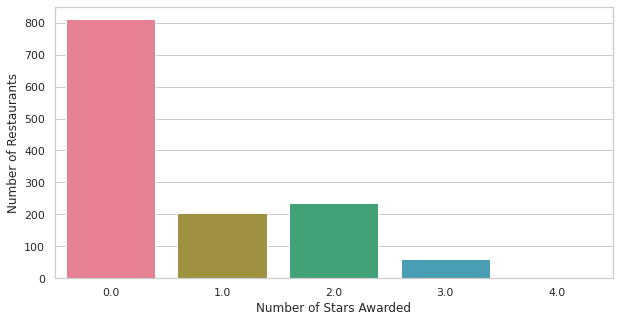

In [0]:
ratings_list = nyt_dining['rating'].apply(lambda x: 0 if x < 1 else x)
ratings_list = ratings_list.groupby(by = ratings_list).count()
ratings_list.sort_index(inplace = True)
f, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(ratings_list.index, ratings_list, palette = 'husl')
ax.set(xlabel = 'Number of Stars Awarded', ylabel = 'Number of Restaurants')
plt.show()

**Plot**

Here, we plot the proportion of restaurants that are of a particular price in each of their ratings categories. For example, from the plot below, we see that all restaurants with four stars — Extraordinary restaurants — are entirely all very expensive restaurants as well.

In [0]:
rating_list = list(nyt_dining['rating'].apply(lambda x: 0 if x < 1 else x))
def priceRange(x):
  if x is not None:
    return int(len(x.strip()))
  else:
    return None
price_list = nyt_dining['priceRange'].apply(lambda x: priceRange(x))
price_list = list(price_list)
raw_data = {'rating': rating_list, 'prices': price_list}
rating_price = pd.DataFrame(raw_data)
rating_price = rating_price.groupby(["rating", "prices"])["prices"].count()
rating_price

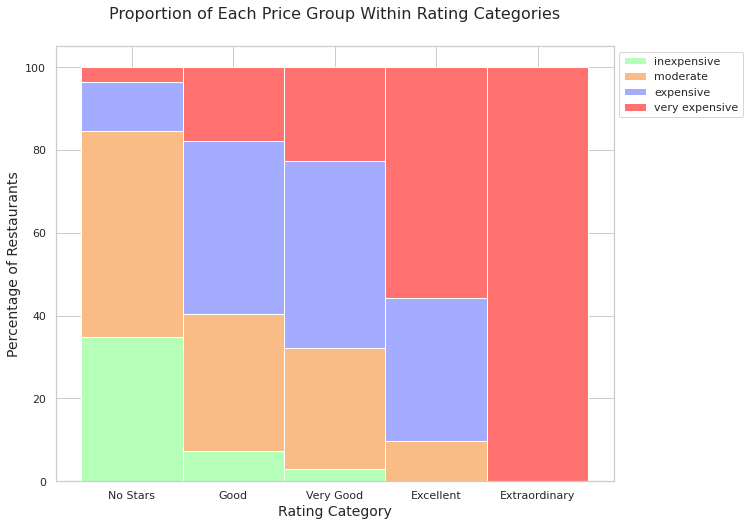

In [0]:
# Credit: https://python-graph-gallery.com/13-percent-stacked-barplot/
rating_price = {'$':[282, 15, 7, 0, 0], '$$':[404, 67, 69, 6, 0], 
                '$$$':[94, 85, 107, 21, 0], '$$$$':[30, 36, 54, 34, 3]}
rating_price = pd.DataFrame(rating_price)
totals = [a + b + c + d for a, b, c, d in zip(rating_price['$'], rating_price['$$'],
                                              rating_price['$$$'], rating_price['$$$$'])]
inexpensive = [i / j * 100 for i, j in zip(rating_price['$'], totals)]
moderate = [i / j * 100 for i, j in zip(rating_price['$$'], totals)]
expensive = [i / j * 100 for i, j in zip(rating_price['$$$'], totals)]
very_expensive = [i / j * 100 for i, j in zip(rating_price['$$$$'], totals)]

# Credit: https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 8)

r = [0, 1, 2, 3, 4]
barWidth = 1
names = ('No Stars', 'Good', 'Very Good', 'Excellent', 'Extraordinary')
plt.bar(r, inexpensive, color = '#b5ffb9', edgecolor = 'white', 
        width = barWidth, label = 'inexpensive')
plt.bar(r, moderate, bottom = inexpensive, color = '#f9bc86', 
        edgecolor = 'white', width = barWidth, label = 'moderate')
plt.bar(r, expensive, bottom = [i + j for i, j in zip(inexpensive, moderate)], 
        color = '#a3acff', edgecolor = 'white', width = barWidth,
        label = 'expensive')
plt.bar(r, very_expensive, 
        bottom = [i + j + k for i, j, k in zip(inexpensive, moderate, expensive)],
        color = '#ff726f', edgecolor = 'white', width = barWidth,
        label = 'very expensive')

font_title = {'weight': 'normal', 'size': 16}
font_label = {'weight': 'normal', 'size': 14}
xlabel = plt.xlabel('Rating Category', font_label)
ylabel = plt.ylabel('Percentage of Restaurants', font_label)
ttl = plt.title('Proportion of Each Price Group Within Rating Categories', font_title)
ttl.set_position([.5, 1.05])
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.xticks(r, names)
plt.show()

# Part 2: Gathering Individual Article Data

Because of how the article is structured, gathering the individual article data requires using a combination of `Selenium` and `Beautiful Soup`. The article is divided in half: a top portion, and a bottom portion. Because articles do not automatically load with all elements immediately visibly on the screen, `Selenium` is needed to automate the action of scrolling down the article to the bottom and waiting for the rest of the article to load. Once all elements are present on the screen, `Beautiful Soup` is used to quickly scrape the rest of the data.


**Step One: Load in Data From Github.**

In [0]:
# Credit: https://projectosyo.wixsite.com/datadoubleconfirm/single-post/2019/04/15/Reading-csv-data-from-Github---Python

nyt_dining = pd.read_excel("https://github.com/andersthequeen/cis545/blob/master/nyt_dining.xlsx?raw=true", 
                           headers = True, index_col = 0)
nyt_dining

**Step Two: Scraping the top half of the article review**

To scrape all 1314 articles, we first load a list of URLs into the `url_list` to iterate through. This is a sample of the top of each restaurant review article, as well as the content of interest highlighted in the red boxes: ![alt text](https://drive.google.com/uc?id=1SDEf5X48ENquW3KCFHXLGs4S94cYTXaB)

For each article, we use `BeautifulSoup` to parse the html from the website. Overall, we seek to collect data to fill these columns — `['URL', 'photo', 'nytPick', 'author', 'time', 'body']` — which represent the following items:
1. The URL of the restaurant review
2. The number of photos the restaurant review features
3. Whether or not the restaurant is an nytPick
4. The author of the article
5. The date the article was written
6. The body text of the article

In [0]:
# Credit: https://stackoverflow.com/questions/28643567/accessing-uninform-dt-dt-dd-dd-tags
# Takes approximately 30 minutes to process this cell block

url_list = list(nyt_dining['URL'])
session = HTMLSession()
nyt_top = pd.DataFrame(columns = ['URL', 'photo', 'nytPick', 'author', 'time', 'body'])

x = 0
for url in url_list:
  r = session.get(url)
  soup = BeautifulSoup(r.text, 'html.parser')

  # 1. Above Article Information
  # 1.1 Number of Photos
  try:
    photo = soup.findAll("p", attrs = {"class": "css-mjef36"})
    photo = int(photo[1].text.replace('Photos', '').strip())
  except:
    photo = ''

  # 1.2 NYT Critics Pick
  pick = soup.find("dd", attrs = {"class": "css-up6b8e"})
  try:
    pick = pick.find("span").text
  except:
    pick = ''

  # 1.3 Author Name
  try:
    author = soup.find("span", attrs = {"class": "css-1baulvz last-byline"}).text
  except:
    author = ''

  # 1.4 Date of Publication
  try:
    time = soup.find("time", attrs = {"class": "css-129k401 e16638kd0"}).text
  except:
    time = ''

  # 2. Article Information
  article_text = ''
  try:
    texts = soup.findAll("p", attrs = {"class": "css-exrw3m evys1bk0"})
    for text in texts:
      article_text += text.text
  except:
    article_text = ''

  nyt_top = nyt_top.append({'URL': url, 'photo': photo, 'nytPick': pick, 
                            'author': author, 'time': time, 'body': article_text}, 
                           ignore_index = True)
  x += 1
  if x % 10 == 0:
    print(x)

**Step Three: Load `nyt_top` into an Excel file.**



In [0]:
# STEP THREE: Download the xlsx.
nyt_top.to_excel("nyt_top.xlsx")
files.download("nyt_top.xlsx")

**Step Four: Define a `scroll_down` function to access bottom article information.**

Because the bottom of each article does not automatically, load, scraping the bottom information from each article again requires `selenium`. By scrolling down to the bottom of the document and waiting, the information originally hidden can be easily revealed.


In [0]:
# STEP FOUR: Define the scroll down function to access bottom article information.
# Credit: https://stackoverflow.com/questions/48850974/selenium-scroll-to-end-of-page-in-dynamically-loading-webpage/48851166#48851166

def scroll_down(self):
  last_height = self.execute_script("return document.body.scrollHeight")
  while True:
    # Scroll down to the bottom.
    self.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    # Wait to load the page.
    time.sleep(2)
    # Calculate new scroll height and compare with last scroll height.
    new_height = self.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
      break
    last_height = new_height

**Step Five: Scraping the bottom half of the article review**

Once the html of the article is revealed, we use `BeautifulSoup` to parse the html from the website. Highlighted in red below are the elements that we seek to extract from the bottom of the article.

![alt text](https://drive.google.com/uc?id=1L_9FL-NFMFECnRrWY2lO7tOiMLOheipw)

Overall, we seek to collect data to fill these columns — `['URL', 'atmosphere', 'noise', 'dishes', 'drinks', 'hours', 'reservations', 'access']` — which represent the following items:
1. The URL of the restaurant review
2. The atmosphere of the restaurant
3. Restaurant noisiness
4. A list of key dishes offered by the restaurant
5. A list of key drinks offered by the restuanrat
6. The restaurant hours
7. Whether or not the restaurant takes reservations
8. The ADA accessibility of the restaurant

In [0]:
url_list = list(nyt_dining['URL'])
nyt_bottom = pd.DataFrame(columns = ['URL', 'atmosphere', 'noise', 'dishes', 
                                     'drinks', 'hours', 'reservations', 'access'])

x = 0
for url in url_list[600:]:
  driver = webdriver.Chrome('chromedriver', chrome_options = chrome_options)
  try:
    driver.get(url)
  except:
    nyt_bottom.append({'URL': url, 'atmosphere': '', 'noise': '', 
                                  'dishes': '', 'drinks': '', 'hours': '',
                                  'reservations': '', 'access': ''},
                                 ignore_index = True)
    continue
  scroll_down(driver)
  soup = BeautifulSoup(driver.page_source, 'html.parser')

  # 3.1 Atmosphere
  try:
    atmosphere = soup.find("div", attrs = {"class": "atmosphere"})
    atmosphere = atmosphere.find("dd").text
  except:
    atmosphere = ''
  
  # 3.2 Noise Level
  try:
    noise = soup.find("div", attrs = {"class": "noiseLevel"})
    noise = noise.find("dd").text
  except:
    noise = ''
  
  # 3.3 Recommended Dishes
  try:
    dishes = soup.find("div", attrs = {"class": "recommendedDishes"})
    dishes = dishes.find("dd").text
  except:
    dishes = ''
  
  # 3.4 Drinks and Wine
  try:
    drinks = soup.find("div", attrs = {"class": "alcoholInfo"})
    drinks = drinks.find("dd").text
  except:
    drinks = ''
  
  # 3.5 Open
  try:
    hours = soup.find("dd", attrs = {"class": "hours"}).text
  except:
    hours = ''

  # 3.6 Reservations
  try:
    reservations = soup.find("dd", attrs = {"class": "reservations"}).text
  except:
    reservations = ''
  
  # 3.7 Wheelchair Access
  try:
    access = soup.find("div", attrs = {"class": "accessibility"})
    access = access.find("dd").text
  except:
    access = ''

  nyt_bottom = nyt_bottom.append({'URL': url, 'atmosphere': atmosphere, 'noise': noise, 
                                  'dishes': dishes, 'drinks': drinks, 'hours': hours,
                                  'reservations': reservations, 'access': access},
                                 ignore_index = True)
  x += 1
  print(x)

**Step Six: Load `nyt_bottom` into an Excel file.**




In [0]:
nyt_bottom.to_excel("nyt_bottom.xlsx")
files.download("nyt_bottom.xlsx")

# Part 3: Cleaning and Piecing Article Data

**Step One: Run installations.**

In [0]:
%%capture
!pip install pandasql

import re
import urllib
import sqlite3
import pandas as pd
import pandasql as ps #SQL on Pandas Dataframe
from datetime import datetime
from dateutil import parser
from sklearn.preprocessing import MultiLabelBinarizer

**Step Two: Download all Excel files.**

In [0]:
# Credit: https://projectosyo.wixsite.com/datadoubleconfirm/single-post/2019/04/15/Reading-csv-data-from-Github---Python

nyt_dining = pd.read_excel("https://github.com/andersthequeen/cis545/blob/master/nyt_dining.xlsx?raw=true", 
                           headers = True, index_col = 0)
nyt_dining_top = pd.read_excel("https://github.com/andersthequeen/cis545/blob/master/nyt_top.xlsx?raw=true", 
                           headers = True, index_col = 0)
nyt_dining_bottom_1 = pd.read_excel("https://github.com/andersthequeen/cis545/blob/master/nyt_bottom_1.xlsx?raw=true",
                                    headers = True, index_col = 0)
nyt_dining_bottom_2 = pd.read_excel("https://github.com/andersthequeen/cis545/blob/master/nyt_bottom_2.xlsx?raw=true",
                                    headers = True, index_col = 0)

**Step Three: Merge Excel files.**

Primarily, we merge on the article URL.

In [0]:
nyt_dining_bottom = nyt_dining_bottom_1.append(nyt_dining_bottom_2, ignore_index = True)
nyt_articles = ps.sqldf('''
SELECT * FROM nyt_dining_top
INNER JOIN nyt_dining_bottom
ON nyt_dining_top.URL == nyt_dining_bottom.URL
''')
nyt_articles = nyt_articles.loc[:,~nyt_articles.columns.duplicated()]
nyt_dining = ps.sqldf('''
SELECT * FROM nyt_dining
INNER JOIN nyt_articles
ON nyt_dining.URL == nyt_articles.URL
''')
nyt_dining = nyt_dining.loc[:,~nyt_dining.columns.duplicated()]

**Step Four: Drop the URL and time columns.**

The time column, I found out, was redundant since we already have the *date* column. For our model, I am presuming that the URL of the article has zero to no impact on the rating that it bestowed upon it.

In [0]:
nyt_dining = nyt_dining.drop(columns = ['URL', 'time'])

**Step Five: One-Hot-Encode the servesCuisine, addressLocality and author columns.**

One-hot-encoding these columns *will* add hundreds of columns to the dataframe... but no worries!

In [0]:
def servesCuisine(x):
  if x is not None:
    return x.split(',')
  else:
    return None
nyt_dining['servesCuisine'] = nyt_dining['servesCuisine'].apply(lambda x: servesCuisine(x))
nyt_dining_cuisine = pd.get_dummies(nyt_dining['servesCuisine'].apply(pd.Series).stack()).sum(level = 0)
nyt_dining_cuisine = nyt_dining_cuisine.rename(columns = lambda x: x.strip())
nyt_dining_cuisine = nyt_dining_cuisine.groupby(by = nyt_dining_cuisine.columns, axis = 1).sum()
nyt_dining_cuisine = nyt_dining_cuisine.astype(int)
nyt_dining = nyt_dining.join(nyt_dining_cuisine)
nyt_dining = nyt_dining.drop(columns = ['servesCuisine'])

In [0]:
nyt_dining = pd.get_dummies(data = nyt_dining, 
                            columns = ['addressLocality', 'author'], 
                            prefix = '', prefix_sep='')

**Step Six: Alter the priceRange column to convert $ into numbers.**

Enumerating the number of dollar signs, e.g. representing "$$$" as "3.0" allows the machine learning model to run smoother.

In [0]:
def priceRange(x):
  if x is not None:
    return int(len(x.strip()))
  else:
    return None
nyt_dining['priceRange'] = nyt_dining['priceRange'].apply(lambda x: priceRange(x))

**Step Seven: Change the date column to datetype.**


In [0]:
nyt_dining['date'] = nyt_dining['date'].apply(lambda x: parser.parse(x))

**Step Eight: Extract numbers from the rating column.**

Currently, the rating column is a little bit messy.

In [0]:
def rating(x):
  if x is not None:
    x = x.strip()
    if len(x) < 20:
      nums = re.findall(r'\d+', x)
      if len(nums) == 1:
        return float(nums[0])
      elif len(nums) == 2:
        return (float(nums[0] + '.' + nums[1]))
      else:
        return 0.0
    else:
      return 0.0
  else:
    return 0.0
nyt_dining['rating'] = nyt_dining['rating'].apply(lambda x: rating(x))

**Step Nine: Change nytPick into a boolean type.**

Basically, *nytPick* represents whether or not the restaurant is "New York Times" approved or not. If it is approved, then the boolean should be *true* and if it is not, then *false.*

In [0]:
def nytPick(x):
  if x is not None:
    if "NYT" in x:
      return True
  return False
nyt_dining['nytPick'] = nyt_dining['nytPick'].apply(lambda x: nytPick(x))

**Step Ten: Run VADER sentiment analysis on the `body` and `atmosphere` columns.**

Credit: https://www.nltk.org/_modules/nltk/sentiment/vader.html

The VADER sentiment analyzer takes in tokenized sentences, and outputs a value between -1 and 1. The closer to -1, the more negative the sentence. The closer to 1, the more positive the sentence is implicated to be. Because both the `body` and `atmosphere` columns are heavily text-based but rich with information, I wanted to codify the text into "positive" or negative" text using the VADER sentiment analyzer.

In [0]:
# Credit: https://www.nltk.org/_modules/nltk/sentiment/vader.html
import nltk
import string
nltk.download('punkt')
nltk.download('words')
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk import tokenize
from nltk.corpus import words
from google.colab import files
from collections import Counter
from nltk.corpus import stopwords 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

Both `sent_scorer_reg` and `sent_scorer_neg` take in a chunk of text and spit out its sentiment score across all its sentences. The difference between `sent_scorer_reg` and `sent_scorer_neg` is that `sent_scorer_neg` more heavily penalizes body text for containing negative sentences.

In [0]:
def sent_scorer_reg(body):
  if body is None:
    return 0.0
  sentences = tokenize.sent_tokenize(body)
  if len(sentences) < 1:
    return 0.0
  total_score = 0.0
  for sentence in sentences:
    ss = sid.polarity_scores(sentence)
    total_score += ss.get('compound')
  return total_score / len(sentences)

In [0]:
def sent_scorer_neg(body):
  if body is None:
    return 0.0
  sentences = tokenize.sent_tokenize(body)
  if len(sentences) < 1:
    return 0.0
  total_score = 0.0
  for sentence in sentences:
    ss = sid.polarity_scores(sentence)
    score = 0.0
    if ss.get('compound') < 0:
      score = ss.get('compound') * 3
    else:
      score = ss.get('compound')
    total_score += score
  return total_score / len(sentences)

In a rather unfashionable approach, I apply the functions established above onto each column, and then insert the columns manually into the `nyt_dining` dataframe.

In [0]:
body_sentiment_reg = nyt_dining['body'].apply(lambda x: sent_scorer_reg(x))

In [0]:
body_sentiment_neg = nyt_dining['body'].apply(lambda x: sent_scorer_neg(x))

In [0]:
nyt_dining.insert(loc = 7, column = 'body_sentiment_reg', value = body_sentiment_reg)

In [0]:
nyt_dining.insert(loc = 8, column = 'body_sentiment_neg', value = body_sentiment_neg)

In [0]:
atmosphere_sentiment = nyt_dining['atmosphere'].apply(lambda x: sent_scorer_reg(x))

In [0]:
nyt_dining.insert(loc = 10, column = 'atmosphere_sentiment', value = atmosphere_sentiment)

In [0]:
nyt_dining = nyt_dining.drop(columns = ['body', 'atmosphere'])

**Step Eleven: One-Hot-Encoding the noise column.**

Because the noise column is also filled with words, I wanted to take out key words and find which restaurants had words inside their "noise" description that matched the key words. Ultimately, after manually looking through a list of most common words throughout all the "noise" text, I settled on these nine key words:

`['loud', 'peak', 'music', 'conversation', 'low', 'noise', 'moderate', 'quiet', 'serene']`

Thus, if a restaurant's noise description contained the word `low` in it, that restaurant would be codified as "1" for the `low` column. If not, then it would be codified as "0."

In [0]:
# STEP TEN: One-Hot-Encoding the noise column
noise_paragraph = ''
for x in nyt_dining['noise']:
  if x is not None:
    noise_paragraph += ' ' + x
noise_paragraph = tokenize.word_tokenize(noise_paragraph)
noise_words_filtered = []
setofwords = set(words.words())
for word in noise_paragraph:
  if word in setofwords:
    noise_words_filtered.append(word)
frequent_noise_words = Counter(noise_words_filtered)
frequent_noise_words = ['loud', 'peak', 'music', 'conversation', 'low', 'noise', 'moderate', 'quiet', 'serene']

In [0]:
def noise_list(text):
  noise_list = []
  if text is not None:
    for word in frequent_noise_words:
      if word in text:
        noise_list.append(word)
  return noise_list
nyt_dining['noise'] = nyt_dining['noise'].apply(lambda x: noise_list(x))
nyt_dining_noise = pd.get_dummies(nyt_dining['noise'].apply(pd.Series).stack()).sum(level = 0)
nyt_dining_noise = nyt_dining_noise.rename(columns = lambda x: x.strip())
nyt_dining_noise = nyt_dining_noise.groupby(by = nyt_dining_noise.columns, axis = 1).sum()
nyt_dining = pd.merge(nyt_dining, nyt_dining_noise, left_index = True, 
                      right_index = True, how = 'left')
nyt_dining[['conversation', 'loud', 'low', 'moderate', 'music', 'noise_y',
            'peak', 'quiet']] = nyt_dining[['conversation', 'loud', 'low',
                                            'moderate', 'music', 'noise_y',
                                            'peak', 'quiet']].fillna(value = 0)
nyt_dining = nyt_dining.drop(columns = ['noise_x'])

**Step Twelve: Counting the number of dishes suggested.**

The dishes column is essentially a list of top recommended dishes. Because I had the idea that the better the restaurant the more likely the reviewer would recommend more dishes, I decided to codify the `dishes` column into the number of dishes suggested. This I achieved by counting the number of columns.

In [0]:
def comma_counter(text):
  if text is not None:
    return text.count(',')
  else:
    return 0
nyt_dining['dishes'] = nyt_dining['dishes'].apply(lambda x: comma_counter(x))

**Step Thirteen: Does the restaurant offer drinks and ADA access?**

If the restaurant review contained a section on either drinks or access, then the restaurant offered drinks and ADA access respectively. So, I codified the `drinks` and `access` columns as booleans.

In [0]:
nyt_dining['drinks'] = nyt_dining['drinks'].apply(lambda x: True if x is not None else False)
nyt_dining['access'] = nyt_dining['access'].apply(lambda x: True if x is not None else False)

**Step Thirteen: When is the restaurant open?**

Similar to how I broke down the `noise` column, I checked for key words in the `hours` description of each article and one-hot-encoded the key words.

In [0]:
hours_paragraph = ''
for x in nyt_dining['hours']:
  if x is not None:
    hours_paragraph += ' ' + x
hours_paragraph = tokenize.word_tokenize(hours_paragraph)
hours_words_filtered = []
setofwords = set(words.words())
for word in hours_paragraph:
  if word in setofwords:
    hours_words_filtered.append(word)
frequent_hours_words = Counter(hours_words_filtered)
frequent_hours_words = ['dinner', 'lunch', 'Sunday', 'Saturday', 'Monday',
                        'Tuesday', 'Friday', 'brunch', 'breakfast', 'Thursday',
                        'Wednesday', 'daily', 'midnight', 'early', 'noon']

In [0]:
def hours_list(text):
  hours_list = []
  if text is not None:
    for word in frequent_hours_words:
      if word in text:
        hours_list.append(word)
  return hours_list
nyt_dining['hours'] = nyt_dining['hours'].apply(lambda x: hours_list(x))
nyt_dining_hours = pd.get_dummies(nyt_dining['hours'].apply(pd.Series).stack()).sum(level = 0)
nyt_dining_hours = nyt_dining_hours.rename(columns = lambda x: x.strip())
nyt_dining_hours = nyt_dining_hours.groupby(by = nyt_dining_hours.columns, axis = 1).sum()
nyt_dining = pd.merge(nyt_dining, nyt_dining_hours, left_index = True, 
                      right_index = True, how = 'left')
nyt_dining[['dinner', 'lunch', 'Sunday', 'Saturday', 'Monday', 'Tuesday', 'Friday', 
            'brunch', 'breakfast', 'Thursday', 'Wednesday', 'daily', 'midnight', 
            'early', 'noon']] = nyt_dining[['dinner', 'lunch', 'Sunday', 'Saturday', 
                                            'Monday', 'Tuesday', 'Friday', 'brunch', 
                                            'breakfast', 'Thursday', 'Wednesday', 
                                            'daily', 'midnight', 'early', 'noon']].fillna(value = 0)
nyt_dining = nyt_dining.drop(columns = ['hours'])

**Step Fourteen: Are reservations taken?**

Either reservations were taken - in which case the word *not* would not appear in the `reservations` description - or they weren't taken, in which case the word *not* would appear in the `reservations` description.

In [0]:
# STEP FOURTEEN: Are reservations taken?
def reservations_taken(x):
  if x is not None:
    x = x.lower()
    if 'not' in x:
      return False
    else:
      return True
  else:
    return True
nyt_dining['reservations'] = nyt_dining['reservations'].apply(lambda x: reservations_taken(x))

**Step Fifteen: Checkpoint and download the cleaned dataframe into Excel.**

In [0]:
nyt_dining.to_excel("nyt_dining_clean.xlsx")
files.download("nyt_dining_clean.xlsx")

### Table Adjustments

Because the `nyt_dining` dataframe downloaded doesn't exactly run perfectly through all machine learning models, some last-minute touchups have to be made here before moving on to Part Four.

**Step One: Set datetime and NA values.**

Because dates don't work quite well in machine learaning models, encoding them as numerical `month`, `year` and `day` values makes the entire affair much easier. We also fill all columns with null values with "0.0" to simplify things.

In [0]:
nyt_dining = pd.read_excel("https://github.com/andersthequeen/cis545/blob/master/nyt_dining_clean.xlsx?raw=true", 
                           headers = True, index_col = 0)
nyt_dining['photo'] = nyt_dining['photo'].fillna(value = 0.0)
nyt_dining = nyt_dining.set_index('Restaurant')
nyt_dining['article_year'] = nyt_dining['date'].dt.year
nyt_dining['article_month'] = nyt_dining['date'].dt.month
nyt_dining['article_day'] = nyt_dining['date'].dt.day
nyt_dining = nyt_dining.drop(columns = ['date'])
nyt_dining = nyt_dining.fillna(0)

**Step Two: Adjust the non-rating values.**

Each article has several different ratings, listed below:
* 4.00 stars — or Extraordinary
* 3.00 stars — or Excellent
* 2.00 stars — or Very Good
* 1.00 stars — or Good
* 0.00 stars — or No Rating
* 0.75 stars — or Satisfactory
* 0.50 stars — or Fair
* 0.25 stars — or Poor

A key assumption I made was that articles that were not rated were good enough that they were better than Satisfactory, but not good enough to warrant a star. This assumption came from various articles that I read, and understanding that a "Satisfactory" review was not actually a positive review. Thus, an article with no rating would be better than an article with a "Satisfactory" rating. Therefore, I encoded the "No Rating" articles with a value of `0.89`.



In [0]:
# 1. Get the number of rows per rating
# 2. Divide it by 780
# 3. Run the for loop to the number, append the block that many times
rating_dict = {0.25: 3, 0.5: 9, 0.75: 18, 1: 203, 2: 237, 3: 61, 4: 3}
for key in rating_dict:
  nyt_rating = nyt_dining.loc[nyt_dining['rating'] == key]
  for i in range(0, int(780 / rating_dict.get(key) - 1)):
    nyt_dining = nyt_dining.append(nyt_rating)

In [0]:
def normalize_0(x):
  if x == 0.00:
    return 0.89
  else:
    return x
nyt_dining['rating'] = nyt_dining['rating'].apply(lambda x: normalize_0(x))

In [0]:
# Adjust for ratings imbalance
nyt_ratings = nyt_dining.groupby('rating').agg('count')
nyt_ratings

In [0]:
nyt_dining.groupby('rating').agg('count')

In [0]:
nyt_dining.to_excel("nyt_dining_clean.xlsx")
files.download("nyt_dining_clean.xlsx")

# Part 4: Implementing Machine Learning

As part of the project, I implemented five different kinds of models. Each of the models contain their own point of evaluation, which I've also listed alongside the model:
1. Simple Linear Regression – RMSE
2. Random Forest Regression – RMSE
3. PCA + Linear Regression – RMSE
4. Random Forest Classification – Accuracy
5. Keras Neural Network – Accuracy

Each model had their own benefits and drawbacks, but for the most part the more "complex" models worked better at predicting the article ratings than the "simpler" models. Below, the first step is to configure Java 8 as well as import a couple necessary items.

### Necessary Imports

In [0]:
%%capture
!pip install pandasql

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from datetime import datetime as dt
import matplotlib.pyplot as plt
from google.colab import files
from datetime import datetime
from matplotlib import cm
import seaborn as sns
import pandasql as ps
import pandas as pd
import numpy as np
import matplotlib
import glob

### Load in `nyt_dining` and its label and features


In [0]:
nyt_dining = pd.read_excel("https://github.com/andersthequeen/cis545/blob/master/nyt_dining_clean.xlsx?raw=true", 
                           headers = True, index_col = 0)
label = nyt_dining.rating
features = nyt_dining.drop(columns = ['rating'])
# Credit: https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
x_train, x_test, y_train, y_test = train_test_split(features, label, 
                                                    test_size = 0.2)

### Model One: Simple Linear Regression

For the simple linear regression model, I divided up `nyt_dining` into `label` and `features`, where the `features` included the `rating` column and the `label` columns included everything but.

Using `train_test_split` and then the `LinearRegression()` model yields a a `mean_squared_error` of approximately 0.3197.

In [0]:
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)
print(mean_squared_error(y_test, y_pred))

### Model Two: Random Forest Regression

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

**Step One: PCA fit-transform.**

Using PCA fit-transform on the data allows me to figure out how many components I should include in the final Random Forest Regression model.

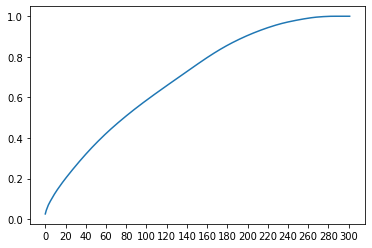

In [5]:
# Credit: https://colab.research.google.com/drive/1IwLI6jBEd6KVqXyNGMocGN8zHHyT7qx1
X2 = StandardScaler().fit_transform(x_train)
pca = PCA(n_components = 302)
X2 = pca.fit_transform(X2)
pca.explained_variance_ratio_

pca_vs_variance = np.cumsum(pca.explained_variance_ratio_)
pca_vs_variance
plt.xticks(np.arange(0, 302, 20.0))
sns.axes_style("darkgrid")
sns.lineplot(data = pca_vs_variance)

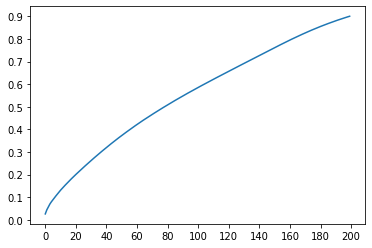

In [6]:
X2 = StandardScaler().fit_transform(x_train)
pca2 = PCA(n_components = 200)
X2 = pca2.fit_transform(X2)
pca2.explained_variance_ratio_

pca2_vs_variance = np.cumsum(pca2.explained_variance_ratio_)
pca2_vs_variance
plt.xticks(np.arange(0, 201, 20.0))
plt.yticks(np.arange(0, 1.1, 0.1))
sns.axes_style("darkgrid")
sns.lineplot(data = pca2_vs_variance)

**Step Two: Tuning the Hyperparameters.**

The two hyperparameters I tuned were `max_depth` and `n_estimators`. In the end, `GridSearchCV` with cross-validation of 3 segments suggests that using an `n_estimators` of 700 with a `max_depth` of 5 will provide better results.

In [0]:
param_grid = {
    'max_depth': [5],
    'n_estimators': [300, 500, 700]
}

In [0]:
#Credit: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                           cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X2, y_train)
grid_search.best_params_

**Step Three: Getting the RMSE.**

Overall, the RMSE of the Random Forest Regression model was highly improved over the original model. Here, I achieve an RMSE of 0.95. This isn't entirely great, given that the entire option set itself spans between the values of 0.0 and 4.0 — but, I'll take what we can get.

In [7]:
# Transform the x_test set
X2T = StandardScaler().fit_transform(x_test)
X2T = pca2.fit_transform(X2T)

# Run RandomForestRegressor using the tuned parameters
rfr = RandomForestRegressor(n_estimators = 700, max_depth = 5)
rfr.fit(X2, y_train)
y_pred = rfr.predict(X2T)

# Get the MSE of the result
np.sqrt(mean_squared_error(y_test, y_pred))

# Much better than regular regression!
# RMSEs: [0.9007, 1.0556, 0.9034]

0.9033714510442654

### Model Three: PCA + Linear Regression

**Spark Garbage**

A lot of Spark Garbage that I imported from a previous homework that I did, necessary to run the Linear Regression Pipeline.

Sent the Java Configuration to version 8 [select option 2].

In [0]:
! sudo apt install openjdk-8-jdk
! sudo update-alternatives --config java

In [2]:
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
!pip install pyspark --user
!pip install seaborn --user
!pip install plotly --user
!pip install imageio --user
!pip install folium --user
!apt update
!apt install gcc python-dev libkrb5-dev
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
import os
spark = SparkSession.builder.appName('ml-hw4').getOrCreate()
%load_ext sparkmagic.magics
#graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure
import os
os.environ['SPARK_HOME'] = '/content/spark-2.4.5-bin-hadoop2.7'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  comerr-dev krb5-multidev libcom-err2 libgssrpc4 libkadm5clnt-mit11
  libkadm5srv-mit11 libkdb5-9
Suggested packages:
  doc-base krb5-doc krb5-user
The following NEW packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9 libkrb5-dev
The following packages will be upgraded:
  libcom-err2
1 upgraded, 7 newly installed, 0 to remove and 28 not upgraded.
Need to get 358 kB of archives.
After this operation, 1,992 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcom-err2 amd64 1.44.1-1ubuntu1.3 [8,848 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgssrpc4 amd64 1.16-2ubuntu0.1 [54.2 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkdb5-9 amd64 1.16-2ubuntu0.1 [37.2 kB]
Get:4 http

**Step One: Neccessary Imports.**

In [0]:
# For the Spark Model:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import PCA
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

**Step Two: Spark Dataframe Preparation.**

Because the initial Pandas dataframe is not perfectly suitable to immedaitely use as a spark dataframe, renaming several problematic columns does the trick.

In [0]:
nyt_dining = pd.read_excel("https://github.com/andersthequeen/cis545/blob/master/nyt_dining_clean.xlsx?raw=true", 
                           headers = True, index_col = 0)
nyt_dining.to_csv ('nyt_dining.csv', index = None, header = True)
nyt_dining = pd.read_csv('nyt_dining.csv')

In [0]:
nyt_dining_sdf = spark.read.csv("nyt_dining.csv", header = True, inferSchema = True)
nyt_dining_sdf = nyt_dining_sdf.withColumnRenamed("Austin, Tex.", "Austin")
nyt_dining_sdf = nyt_dining_sdf.withColumnRenamed("Santa Monica, Calif.", "Santa Monica")
nyt_dining_sdf = nyt_dining_sdf.withColumnRenamed("Washington D.C.", "Washington DC")
nyt_dining_sdf = nyt_dining_sdf.withColumnRenamed("Frank J. Prial", "Frank J Prial")

**Step Three: Briefly run a much better Linear Regression.**

Within the PCA + Linear Regression model, I have the chance to run another Linear Regression model. This time, my model runs *much* better than the first Linear Regression model, with an achieved RMSE of approximately 0.5052. This RMSE is much better than the RMSE achieved by the Random Forest Regressor.

In [6]:
columns_to_use = [i for i in nyt_dining_sdf.columns if i not in ['rating']]
assembler = VectorAssembler(inputCols = columns_to_use , outputCol = "features")
modified_data_sdf = assembler.transform(nyt_dining_sdf)
train_sdf, test_sdf = modified_data_sdf.randomSplit([0.8, 0.2], seed = 123)
lr = LinearRegression(featuresCol = 'features', labelCol = 'rating')
lr_model = lr.fit(train_sdf)
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.505242
r2: 0.840936


**Step Four: Building the PCA + Linear Regression Pipeline.**

I use 200 columns, rather than all 302.

In [0]:
pca = PCA(k = 200, inputCol = 'features', outputCol = 'pca_process')
lr_pca = LinearRegression(featuresCol = 'pca_process', labelCol = 'rating', predictionCol = 'prediction')
pipeline = Pipeline(stages = [pca, lr_pca])
X3 = pipeline.fit(train_sdf)

In [8]:
train_predictions = X3.transform(train_sdf)
evaluator = RegressionEvaluator(labelCol = 'rating', 
                                predictionCol = 'prediction',
                                metricName = 'rmse')
training_rmse_pca = evaluator.evaluate(train_predictions)
training_rmse_pca

0.518233650093363

**Step Five: Getting the RMSE.**

The final RMSE of the PCA + pipeline model — approximately 0.535 — this is actually worse than the Linear Regression model fitted in the first half of this section! This is quite interesting. I am not sure why this was the case.

In [9]:
predictions = X3.transform(test_sdf)
evaluator = RegressionEvaluator(labelCol = 'rating', 
                                predictionCol = 'prediction',
                                metricName = 'rmse')
test_rmse_pca = evaluator.evaluate(predictions)
test_rmse_pca

0.5352953226204413

### Model Four: Random Forest Classification

**Step One: Neccessary Imports.**

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Step Two: Separating out the label and features columns.**

Using `train_test_split`, I am further able to divide out the `x_train`, `y_train`, `x_val`, `y_val`, `x_test` and `y_test` datasets from the original `nyt_dining` dataset.

In [0]:
nyt_dining = pd.read_excel("https://github.com/andersthequeen/cis545/blob/master/nyt_dining_clean.xlsx?raw=true", 
                           headers = True, index_col = 0)
factor = pd.factorize(nyt_dining['rating'])
nyt_dining.rating = factor[0]
definitions = factor[1]
label = nyt_dining.rating
features = nyt_dining.drop(columns = ['rating'])
x_train, x_test, y_train, y_test = train_test_split(features, label, 
                                                    test_size = 0.15)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size = 0.15, 
                                                  random_state = 1)

**Step Three: Scaling the Train, Validation and Testing Datasets.**

Here, I come to the conclusion that the preferable number of components is approximately 120, rather than 302.

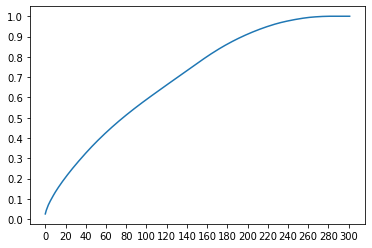

In [3]:
X4 = StandardScaler().fit_transform(x_train)
pca = PCA(n_components = 302)
X4 = pca.fit_transform(X4)
pca.explained_variance_ratio_

pca_vs_variance = np.cumsum(pca.explained_variance_ratio_)
pca_vs_variance
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 302, 20.0))
sns.axes_style("darkgrid")
sns.lineplot(data = pca_vs_variance)

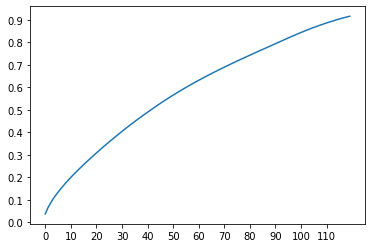

In [4]:
X4V = StandardScaler().fit_transform(x_val)
pca = PCA(n_components = 120)
X4V = pca.fit_transform(X4V)
pca.explained_variance_ratio_

pca_vs_variance = np.cumsum(pca.explained_variance_ratio_)
pca_vs_variance
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 120, 10.0))
sns.axes_style("darkgrid")
sns.lineplot(data = pca_vs_variance)
# Using only three columns to explain.

In [0]:
X4T = StandardScaler().fit_transform(x_test)
pca2 = PCA(n_components = 120)
X4T = pca2.fit_transform(X4T)

**Step Four: Fitting the Random Forest Classifier.**

In [0]:
# Credit: https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6
forest = RandomForestClassifier(random_state = 1)
modelF = forest.fit(X4V, y_val)
y_predF = modelF.predict(X4T)

**Step Five: Tuning the hyperparameters.**

After using `GridSearchCV` and tuning for `max_depth` and `n_estimators`, I found that a `max_depth` of 20 and `n_estimators` of 80 was most optimal to properly fit the Random Forest Classifier.

In [21]:
param_grid = {
    'max_depth': [20, 50],
    'n_estimators': [80, 120]
}
gridF = GridSearchCV(estimator = forest, param_grid = param_grid,
                     cv = 5, verbose = 1, n_jobs = -1)
bestF_train = gridF.fit(X4V, y_val)
bestF_train.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.3s finished


{'max_depth': 20, 'n_estimators': 120}

**Step Six: Getting the Accuracy Score.**

The final RMSE of the Random Forest Classifier hovered around 2.7913. However, this is not a particularly good measure of the Random Forest Classifier performance. To truly measure the Random Forest Classifier perforance, I attempted to use an accuracy metric. The accuracy metric shows that about 20.88% of the time, my model predicted the correct score. This is only very slightly better than random chance, which would be about 14.29%.

In [0]:
rfc = RandomForestClassifier(n_estimators = 120, max_depth = 20)
rfc.fit(X4V, y_val)
prediction = rfc.predict(X4T)
y_pred = prediction

In [27]:
accuracy_score(y_pred, y_test)
# Accuracies: [0.2088, 0.2099, 0.1998, 0.1773, 0.1920]

0.1919191919191919

### Model Five: Keras Neural Network

**Step One: Necessary Imports.**

In [0]:
%%capture
import argparse
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import load_model
from keras import optimizers
from keras import utils
import seaborn as sns
import tensorflow as tf
import pandas as pd

In [0]:
nyt_dining = pd.read_excel("https://github.com/andersthequeen/cis545/blob/master/nyt_dining_clean.xlsx?raw=true", 
                           headers = True, index_col = 0)
factor = pd.factorize(nyt_dining['rating'])
nyt_dining.rating = factor[0]
definitions = factor[1]
label = nyt_dining.rating
features = nyt_dining.drop(columns = ['rating'])
# Credit: https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
x_train, x_test, y_train, y_test = train_test_split(features, label, 
                                                    test_size = 0.2)

**Step Two: Scaling the data.**

In [0]:
X5 = StandardScaler().fit_transform(x_train)
pca2 = PCA(n_components = 200)
X5 = pca2.fit_transform(X5)

In [0]:
X5T = StandardScaler().fit_transform(x_test)
pca3 = PCA(n_components = 200)
X5T = pca2.fit_transform(X5T)

In [0]:
Y5 = to_categorical(y_train)

In [0]:
Y5T = to_categorical(y_test)

**Step Three: Building and running the model.**

Using various layers, primarily `relu` as the activation function, and prioritizing the reduction of `mean_squared_error` to increase the performance of the model.

In [0]:
model = Sequential()
model.add(Dense(150, input_dim = 200, activation = 'relu'))
model.add(Dense(100, input_dim = 200, activation = 'relu'))
model.add(Dense(50, input_dim = 200, activation = 'relu'))
model.add(Dense(8, activation = 'softmax'))
model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])

In [111]:
history = model.fit(X5, Y5, epochs = 20, batch_size = 30)

Epoch 1/20
4752/4752 [==============================] - 0s 79us/step - loss: 0.8814 - accuracy: 0.7393
Epoch 2/20
4752/4752 [==============================] - 0s 57us/step - loss: 0.2755 - accuracy: 0.9053
Epoch 3/20
4752/4752 [==============================] - 0s 56us/step - loss: 0.1670 - accuracy: 0.9470
Epoch 4/20
4752/4752 [==============================] - 0s 58us/step - loss: 0.1227 - accuracy: 0.9663
Epoch 5/20
4752/4752 [==============================] - 0s 59us/step - loss: 0.0998 - accuracy: 0.9726
Epoch 6/20
4752/4752 [==============================] - 0s 62us/step - loss: 0.0665 - accuracy: 0.9819
Epoch 7/20
4752/4752 [==============================] - 0s 58us/step - loss: 0.0468 - accuracy: 0.9878
Epoch 8/20
4752/4752 [==============================] - 0s 59us/step - loss: 0.0383 - accuracy: 0.9903
Epoch 9/20
4752/4752 [==============================] - 0s 58us/step - loss: 0.0333 - accuracy: 0.9907
Epoch 10/20
4752/4752 [==============================] - 0s 59us/step - l

**Step Four: Evaluating the model.**

Overall, the neural network model performed the best out of all five models. The accuracy given by the neural network achieved 80.81%, much better than random chance — which would have been 12.5%.

In [0]:
accuracy_list = pd.Series(history.history['accuracy']) 
loss_list = pd.Series(history.history['loss'])

**Plot**

Here, I plot the accuracy of each epoch, from 0 to 100.

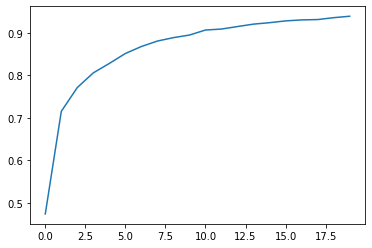

In [81]:
sns.lineplot(accuracy_list.index, accuracy_list)

**Plot**

Here, I plot the loss of each epoch, from 0 to 100.

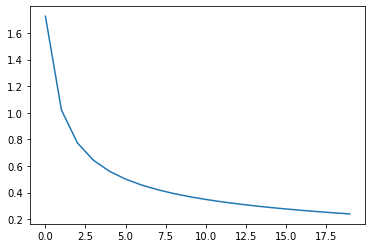

In [82]:
sns.lineplot(loss_list.index, loss_list)

In [113]:
score = model.evaluate(X5T, Y5T, batch_size = 30)
print("The accuracy of this model is: " + str(score[1]))
print("The loss of this model is: " + str(score[0]))

1188/1188 [==============================] - 0s 30us/step
The accuracy of this model is: 0.20875421166419983
The loss of this model is: 7.720073495248352
